Install MedMNIST

In [68]:
# !pip install medmnist
# !pip install einops

Imports

In [69]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

import einops

In [70]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


We first work on a 2D dataset with size 28x28

In [71]:
data_flag = 'bloodmnist'
# data_flag = 'breastmnist' OR 'pathmnist"
download = True

NUM_EPOCHS = 1
batch_size = 1
lr = 0.001

device = "cuda:0" if torch.cuda.is_available() else "cpu"
patch_size = 14
latent_size = 28
n_channels = 1
num_heads = 2
num_encoders = 12
dropout = 0.1
num_classes = 8
#training = True
#size = 28


info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [72]:
print(info)
print(task)
print(n_channels)
print(n_classes)
print(DataClass)

{'python_class': 'BloodMNIST', 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.', 'url': 'https://zenodo.org/records/10519652/files/bloodmnist.npz?download=1', 'MD5': '7053d0359d879ad8a5505303e11de1dc', 'url_64': 'https://zenodo.org/records/10519652/files/bloodmnist_64.npz?download=1', 'MD5_64': '2b94928a2ae4916078ca51e05b6b800b', 'url_128': 'https://zenodo.org/records/10519652/files/bloodmnist_128.npz?download=1', 'MD5_128': 'adace1e0ed228fccda1f39692059dd4c', 'url_224': 'https://zenodo.org/records/10519652/files/bloodmnist_224.npz

First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [73]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(), #from PIL (Python Image Library Format) to PyTorch Tensor, normalised to [0,1]
    transforms.Normalize(mean=[.5], std=[.5]) #(image-mean)/std --> scaling [-1,1]
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, drop_last = True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last = True)

In [74]:
print(train_dataset)
print("===================")
print(test_dataset)
print("===================")
print(train_loader)

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: /home/wiebketeetz/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    L

In [75]:
# visualization

train_dataset.montage(length=1)

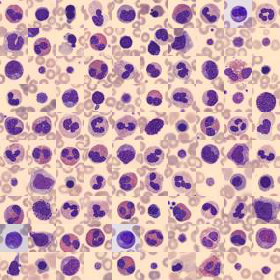

In [76]:
# montage

train_dataset.montage(length=10)

Set Parameters and Implement Encoder-Block for ViT

In [77]:
class InputEmbedding(nn.Module):
    def __init__(self, patch_size = patch_size, n_channels = n_channels, device = device, latent_size = latent_size, batch_size = batch_size):
        super(InputEmbedding, self).__init__()
        self.latent_size = latent_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.device = device
        self.batch_size = batch_size
        self.input_size = self.patch_size*self.patch_size*self.n_channels

        #Linear Projection
        self.linearProjection = nn.Linear(self.input_size, self.latent_size)

        #Class Token
                                              # how many in 1 batch? 1Token  dimensions
        self.class_token = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device)

        #Positional Embedding
        self.pos_embedding =nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device)

    def forward(self, input_data):
        input_data = input_data.to(self.device)

        # Patchify Input Image
        patches = einops.rearrange(
            input_data, "b c (h h1) (w w1) -> b (h w) (h1 w1 c)", h1 = self.patch_size, w1 = self.patch_size)
        
        linear_projection = self.linearProjection(patches).to(self.device)
        b, n, _ = linear_projection.shape

        linear_projection = torch.cat((self.class_token, linear_projection), dim = 1) #entlang der 1. Dim hinzugefügt
        pos_embed = einops.repeat(self.pos_embedding, "b 1 d -> b m d", m = n + 1)

        linear_projection += pos_embed

        return linear_projection

In [78]:
class EncoderBlock(nn.Module):
    def __init__(self, latent_size = latent_size, num_heads = num_heads, device = device, dropout = dropout):
        super(EncoderBlock, self).__init__()

        self.latent_size = latent_size
        self.num_heads = num_heads
        self.device = device
        self.dropout = dropout

        #Normalization layer
        self.norm = nn.LayerNorm(self.latent_size)
      
        self.multihead = nn.MultiheadAttention(
            self.latent_size, self.num_heads, dropout = self.dropout)
        
        self.enc_MLP = nn.Sequential(
            nn.Linear(self.latent_size, self.latent_size*4),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.latent_size*4,self.latent_size),
            nn.Dropout(self.dropout)
        )

    def forward(self, embedded_patches):
        firstnorm_out = self.norm(embedded_patches)
        attention_out = self.multihead(firstnorm_out, firstnorm_out, firstnorm_out)[0]

        #first residual connection
        first_added = attention_out + embedded_patches

        secondnorm_out = self.norm(first_added)
        ff_output = self.enc_MLP(secondnorm_out)

        output = ff_output + first_added

        #print(embedded_patches.size())
        #print(output.size())

        return output

Test Encoder Block

In [79]:
sample1 = train_dataset[0]
image_tensor1, label1 = sample1

sample2 = train_dataset[0]
image_tensor2, label2 = sample2

test_encoder = EncoderBlock().to(device)
test_encoder(image_tensor1)

tensor([[[ 1.1182,  1.4892,  0.4920,  ...,  1.4555,  0.2295,  0.3591],
         [ 1.3591,  2.0399,  0.7603,  ...,  1.2915,  0.7618,  0.5386],
         [ 1.5012,  2.0208,  1.1126,  ...,  1.2589,  1.0665,  0.7777],
         ...,
         [ 0.5760,  0.5667,  1.0569,  ...,  0.5050,  1.4712,  1.4092],
         [ 0.4469,  0.4892,  1.2733,  ...,  0.7299,  1.3011,  1.5525],
         [ 0.8412,  0.8146,  1.3831,  ...,  0.5723,  1.4128,  1.3168]],

        [[ 0.7409,  1.4475,  0.3372,  ...,  1.0114,  0.3286,  0.3140],
         [ 1.0342,  1.7321,  0.6041,  ...,  1.0984,  0.6024,  0.4181],
         [ 1.3217,  1.8685,  0.6850,  ...,  1.2186,  0.7951,  0.6289],
         ...,
         [ 0.4866,  0.4111,  0.8745,  ...,  0.5564,  0.7488,  1.0974],
         [ 0.2033,  0.1528,  0.8719,  ...,  0.3459,  1.0584,  1.3281],
         [ 0.4861,  0.5033,  0.8912,  ...,  0.6054,  0.7642,  0.8751]],

        [[ 0.8474,  1.3281, -0.0520,  ...,  0.8398, -0.3295, -0.3295],
         [ 0.9748,  1.6547,  0.1374,  ...,  0

Implement ViT

In [80]:
class ViT(nn.Module):
    def __init__(self, num_encoders=num_encoders, latent_size=latent_size, device=device, num_classes=num_classes, dropout=dropout):
        super(ViT, self).__init__()

        self.num_encoders = num_encoders
        self.latent_size = latent_size
        self.device = device
        self.num_classes = num_classes
        self.dropout = dropout

        self.embedding = InputEmbedding()

        #Create Stack of Encoders
        self.encStack = nn.ModuleList(EncoderBlock() for i in range(self.num_encoders))

        self.MLP_head = nn.Sequential(
            nn.LayerNorm(self.latent_size),
            nn.Linear(self.latent_size, self.latent_size),
            nn.Linear(self.latent_size, self.num_classes)
        )

    def forward(self, test_input):
        enc_output = self.embedding(test_input)

        for enc_layer in self.encStack:
            enc_output = enc_layer(enc_output)

        cls_token_embed = enc_output[:, 0]

        return self.MLP_head(cls_token_embed)

In [81]:
model = ViT().to(device)

Test ViT

In [82]:
print(image_tensor1.size())
image_tensor1_vit = image_tensor1.unsqueeze(0)
image_tensor2_vit = image_tensor2.unsqueeze(0)
image_tensor = torch.cat((image_tensor1_vit, image_tensor2_vit), dim = 0)

vit_output = model(image_tensor1.unsqueeze(0))

print(vit_output)
print(vit_output.size())

torch.Size([3, 28, 28])
tensor([[ 0.1224,  0.1189,  0.0807,  0.0981,  0.1232, -0.2234, -0.2177,  0.3659]],
       grad_fn=<AddmmBackward0>)
torch.Size([1, 8])


Define the Loss Function

In [83]:
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Next, we start to train and evaluate!

In [84]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        #print(outputs.size())
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze(dim = 1).long()
            #print(targets.size())
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 11959/11959 [02:57<00:00, 67.56it/s]


In [85]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            #print(inputs.shape)
            #print(inputs.size())
            #print(targets.size())
            outputs = model(inputs)
            #print(outputs.size())
            #print(targets)
            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                #targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

#Assertion Error bei Batch Size > 1

==> Evaluating ...
train  auc: 0.500  acc:0.195
test  auc: 0.500  acc:0.195
